Project: Snooker Pool Table.

Contributors: Eli Guy [ID:204677405], Stas Vinagradov [ID: 321338659]

Purpose: Make a side screen during a game of snooker, which tracks the position of the balls. 


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

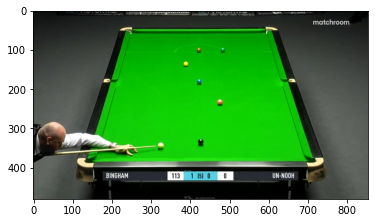

In [3]:
#taking the frist frame
cap = cv2.VideoCapture("P6_Snooker.mp4")
ret, firstframe_org = cap.read()
firstframe_org = cv2.cvtColor(firstframe_org,cv2.COLOR_BGR2RGB)
plt.imshow(firstframe_org)
plt.show()
width = firstframe_org.shape[1]
height = firstframe_org.shape[0]

The first thing we want to do is use hough lines, to find the snooker table and adjust the prespective accordingly.

Since the snooker table is a distinct green color, our first step  is too create a color filter 

In [4]:
#making green mask
firstframe_hsv = cv2.cvtColor(firstframe_org,cv2.COLOR_RGB2HSV)
upper = np.array([65,255,240])
lower = np.array([40,150,70])
mask_green =cv2.inRange(firstframe_hsv,lower,upper)



After we created our filter, all we need is the outer lines. We will use Canny edge detection for that. 
When we get our edges, we can accurrately calculate the Hough lines.

In [5]:
#detecting edges using canny 
edges = cv2.Canny(mask_green,5,50)

#detecting houghlines
lines = cv2.HoughLines(edges,rho=1,theta=np.pi/180,threshold=170)
firstframe_copy = firstframe_org.copy()
#this list will be used later for detecting intersection
line_points = [] 


#drawing detected line
for rho,theta in lines[:,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    x2 = int(x0 - 1000*(-b))
    
    y1 = int(y0 + 1000*(a))
    y2 = int(y0 - 1000*(a))
    cv2.line(firstframe_copy,(x1,y1),(x2,y2),(0,0,255),3)
    line_points.append([[x1,y1],[x2,y2]])
    


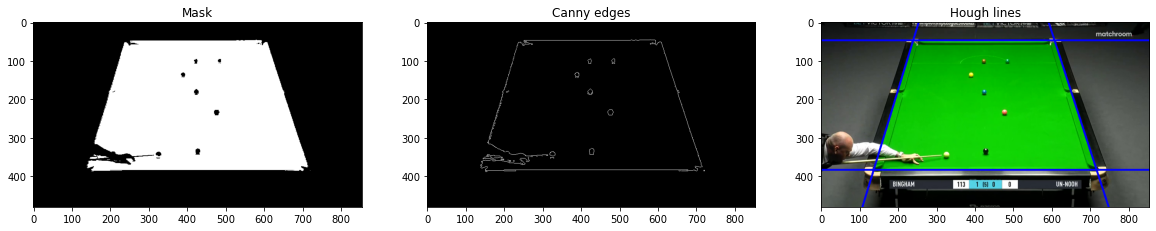

In [6]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Mask")
plt.imshow(mask_green,cmap='gray')
plt.subplot(1,3,2)
plt.title("Canny edges")
plt.imshow(edges,cmap='gray')
plt.subplot(1,3,3)
plt.title("Hough lines")
plt.imshow(firstframe_copy)
plt.show()

Now that we have our Hough lines, we shall find the intersection between them
using an intersection function.
source:https://stackoverflow.com/questions/3252194/numpy-and-line-intersections

In [6]:
def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1


In [7]:
intersec_points = []
for i in range(len(line_points)):
    point_a = line_points[i]
    #print(point_a[1])
    for j in range(i+1,len(line_points)):
        point_b = line_points[j]
        intersect = seg_intersect(np.array(point_a[0]),np.array(point_a[1]),np.array(point_b[0]),np.array(point_b[1]))
        if(intersect[0] > 0 and intersect[0] < 1000 and intersect[1] > 0  and intersect[1] <1000): 
            intersec_points.append(intersect)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


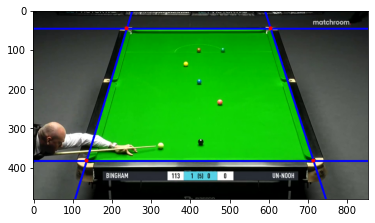

In [8]:
for i in intersec_points:
    cv2.circle(firstframe_copy,((int)(i[0]),(int)(i[1])),5,(255,0,0),-1)
plt.imshow(firstframe_copy)
plt.show()

Now that we have the needed keypoints, we can use warp perspective to adjust the picture.

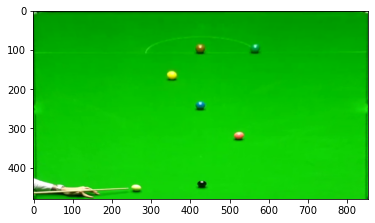

In [9]:
pts_to_adjust = np.float32([[intersec_points[3][0]+10,intersec_points[3][1]+10],[intersec_points[2][0]-10,intersec_points[2][1]+10],[intersec_points[1][0]+20,intersec_points[1][1]-10],[intersec_points[0][0]-20,intersec_points[0][1]-10]])
pts_orig = np.float32([[0,0], [width,0], [0,height], [width,height]])
mat = cv2.getPerspectiveTransform(pts_to_adjust,pts_orig);
img_out = cv2.warpPerspective(firstframe_org,mat,(width,height))
plt.imshow(img_out)

Let's resize the image a bit to fit our scale

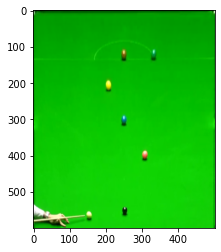

In [10]:
img_out_resize = cv2.resize(img_out,(500,600))
plt.imshow(img_out_resize)
plt.show()

Test run to see if the prespective transform works for the entire video so that we can warp the prespective 

In [12]:
cap2 = cv2.VideoCapture("P6_Snooker.mp4")
while True:
    ret, frame = cap2.read()
    if ret == True:
        img_out = cv2.warpPerspective(frame,mat,(width,height))
        img_out_resize = cv2.resize(img_out,(500,600))
        cv2.imshow("test",img_out_resize)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv2. destroyAllWindows()
cap.release()



Now that we know that warping the prespective works for the entire video, we can move on to detecting and tracking the balls


First we will create a new green background 

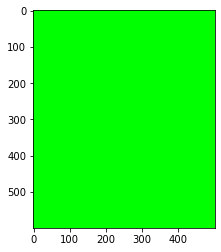

In [11]:
green_screen = np.zeros_like(img_out_resize)
green_screen[:] = (0,255,0)
plt.imshow(green_screen)
plt.show()

Now that we have made our green background, we shall make a mask for each ball such that we can detect each ball seperately

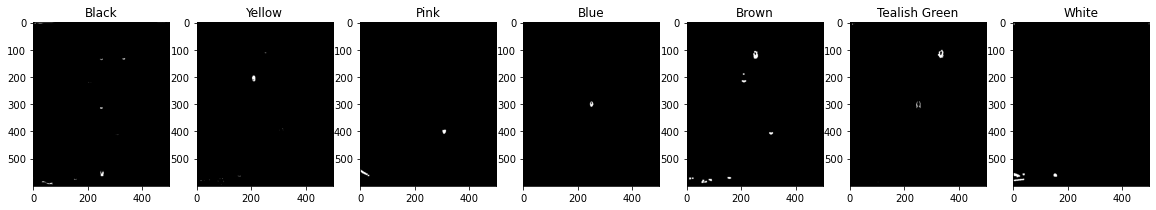

In [12]:
ts_to_adjust = np.float32([[intersec_points[3][0]+10,intersec_points[3][1]+10],[intersec_points[2][0]-10,intersec_points[2][1]+10],[intersec_points[1][0]+20,intersec_points[1][1]-10],[intersec_points[0][0]-20,intersec_points[0][1]-10]])
pts_orig = np.float32([[0,0], [width,0], [0,height], [width,height]])
mat = cv2.getPerspectiveTransform(pts_to_adjust,pts_orig);
img_out = cv2.warpPerspective(firstframe_org,mat,(width,height))

img_out_resize = cv2.resize(img_out,(500,600))

#kernel for filtering 
kernel = np.ones((5, 5), np.uint8) 
img_out_hsv = cv2.cvtColor(img_out_resize, cv2.COLOR_RGB2HSV)
upper = np.array([68,255,78])
lower = np.array([60,0,0])
mask_black =cv2.inRange(img_out_hsv,lower,upper)

#making the masks for each ball 
upper = np.array([35,255,255])
lower = np.array([30,100,150])
mask_yellow =cv2.inRange(img_out_hsv,lower,upper)
upper = np.array([20,255,255])
lower = np.array([0,0,0])
mask_pink =cv2.inRange(img_out_hsv,lower,upper)
mask_pink =cv2.erode(mask_pink,kernel)
mask_pink =cv2.dilate(mask_pink, kernel)
upper = np.array([100,255,240])
lower = np.array([80,50,0])
mask_blue =cv2.inRange(img_out_hsv,lower,upper)
upper = np.array([55,255,200])
lower = np.array([5,150,0])
mask_brown =cv2.inRange(img_out_hsv,lower,upper)
mask_brown =cv2.erode(mask_brown,kernel)
mask_brown =cv2.dilate(mask_brown, kernel)
upper = np.array([85,255,180])
lower = np.array([61,200,100])
mask_tealish_green =cv2.inRange(img_out_hsv,lower,upper)
upper = np.array([100,150,255])
lower = np.array([30,0,140])
mask_white =cv2.inRange(img_out_hsv,lower,upper)
mask_white =cv2.erode(mask_white,kernel)
mask_white =cv2.dilate(mask_white, kernel)

plt.figure(figsize=(20,20))
plt.subplot(1,7,1)
plt.imshow(mask_black,cmap="gray")
plt.title("Black")
plt.subplot(1,7,2)
plt.title("Yellow")
plt.imshow(mask_yellow,cmap="gray")
plt.subplot(1,7,3)
plt.title("Pink")
plt.imshow(mask_pink,cmap="gray")
plt.subplot(1,7,4)
plt.title("Blue")
plt.imshow(mask_blue,cmap="gray")
plt.subplot(1,7,5)
plt.title("Brown")
plt.imshow(mask_brown,cmap="gray")
plt.subplot(1,7,6)
plt.title("Tealish Green")
plt.imshow(mask_tealish_green,cmap="gray")
plt.subplot(1,7,7)
plt.title("White")
plt.imshow(mask_white,cmap="gray")
plt.show()


Now that we have our masks, we can plot each ball to the green background. We shall do so by using the masks to filter for a specific color and Hough Circles to detect the balls themselves. 

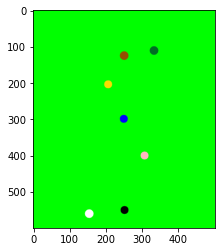

In [13]:
#tracking each ball indvidually using masks and hough circles 

green_screen_t = green_screen.copy()
circles= cv2.HoughCircles(mask_black,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=16,param2=4,minRadius=6,maxRadius=7)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    cv2.circle(green_screen_t,(x,y),r+5,(0,0,0),-1)
    black_start =(x,y)
circles= cv2.HoughCircles(mask_yellow,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=16,param2=4,minRadius=6,maxRadius=7)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    yellow_start =(x,y)
    cv2.circle(green_screen_t,(x,y),r+5,(250,220,0),-1)
circles= cv2.HoughCircles(mask_pink,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=16,param2=4,minRadius=6,maxRadius=7)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    pink_start =(x,y)
    cv2.circle(green_screen_t,(x,y),r+5,(255,182,193),-1)
circles= cv2.HoughCircles(mask_blue,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=16,param2=4,minRadius=6,maxRadius=7)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    blue_start =(x,y)
    cv2.circle(green_screen_t,(x,y),r+5,(0,0,255),-1)
circles= cv2.HoughCircles(mask_brown,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=4,minRadius=7,maxRadius=8)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    brown_start =(x,y)
    cv2.circle(green_screen_t,(x,y),r+5,(150,75,0),-1)
circles= cv2.HoughCircles(mask_tealish_green,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=4,minRadius=7,maxRadius=8)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    tealish_green_start =(x,y)
    cv2.circle(green_screen_t,(x,y),r+5,(0, 109, 37),-1)
circles= cv2.HoughCircles(mask_white,method=cv2.HOUGH_GRADIENT,dp=1,minDist=5,param1=1,param2=4,minRadius=7,maxRadius=8)
circles = circles.astype(np.int)
for (x,y,r) in circles[0]:
    white_start =(x,y)
    cv2.circle(green_screen_t,(x,y),r+5,(255, 255, 255),-1)

plt.imshow(green_screen_t)
plt.show()

Now that we have the initial postion of the balls all we have to do is track their motion across the table. For that we shall use color masks and hough circles again. Only now with a small change. We will also use a Sliding window so that when we, for example, we track the blue ball we will only look in the surronding area of blue ball based on its position the last frame. 

In [14]:


cap3 = cv2.VideoCapture("P6_Snooker.mp4")
ret, frame = cap3.read()
Width = int(cap3.get(cv2.CAP_PROP_FRAME_WIDTH))
Height = int(cap3.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap3.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 

#out = cv2.VideoWriter('final_video.mp4',fourcc, FPS, (Width,Height)) 

black_last_pos =(0,0)
yellow_last_pos =(0,0)
pink_last_pos =(0,0)
blue_last_pos =(0,0)
brown_last_pos =(0,0)
tealish_green_last_pos =(0,0)
white_last_pos =(0,0)
black_notdrawn = 0 
while True:
    ret, frame = cap3.read()
    if ret == True:
        img_out = cv2.warpPerspective(frame,mat,(width,height))
        img_out_resize = cv2.resize(img_out,(500,600))
        kernel = np.ones((6, 6), np.uint8) 
        img_out_hsv = cv2.cvtColor(img_out_resize, cv2.COLOR_BGR2HSV)
        upper = np.array([60,255,60])
        lower = np.array([55,230,0])
        mask_black =cv2.inRange(img_out_hsv,lower,upper)
        mask_black =cv2.erode(mask_black,kernel)
        mask_black =cv2.dilate(mask_black, kernel)
        upper = np.array([37,255,255])
        lower = np.array([28,100,150])
        mask_yellow =cv2.inRange(img_out_hsv,lower,upper)
        upper = np.array([30,255,255])
        lower = np.array([0,100,120])
        mask_pink =cv2.inRange(img_out_hsv,lower,upper)
        mask_pink =cv2.erode(mask_pink,kernel)
        mask_pink =cv2.dilate(mask_pink, kernel)
        upper = np.array([110,255,210])
        lower = np.array([78,70,0])
        mask_blue =cv2.inRange(img_out_hsv,lower,upper)
        upper = np.array([55,255,250])
        lower = np.array([10,50,0])
        mask_brown =cv2.inRange(img_out_hsv,lower,upper)
        mask_brown =cv2.erode(mask_brown,kernel)
        mask_brown =cv2.dilate(mask_brown, kernel)
        upper = np.array([120,255,255])
        lower = np.array([61,0,160])
        mask_tealish_green =cv2.inRange(img_out_hsv,lower,upper)
        mask_tealish_green =cv2.erode(mask_tealish_green,kernel)
        mask_tealish_green =cv2.dilate(mask_tealish_green,kernel)
        
        upper = np.array([100,140,255])
        lower = np.array([30,0,245])
        mask_white =cv2.inRange(img_out_hsv,lower,upper)
        mask_white =cv2.erode(mask_white,kernel)
        mask_white =cv2.dilate(mask_white,kernel)
        green_screen_t = np.zeros_like(img_out_resize)
        green_screen_t[:] = (0,255,0)
        cv2.imshow("brown",cv2.cvtColor(mask_brown,cv2.COLOR_GRAY2BGR))
        
        if(black_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_black[black_start[1] - 20:black_start[1] + 20,black_start[0] - 20:black_start[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[black_start[1] - 20:black_start[1] + 20,black_start[0] - 20:black_start[0] + 20],(x,y),14,(0,0,0),-1)
                    black_last_pos = (int(black_start[0] - 20 +x),int( black_start[1]- 20 +y))
                    black_notdrawn = 0
            else:
                black_notdrawn=black_notdrawn+1
        else:
            if(black_last_pos[0] - 20 < 0):
                black_last_pos = (black_last_pos[0] -(black_last_pos[0] - 20),black_last_pos[1])
            if(black_last_pos[1] - 20 < 0):
                black_last_pos = (black_last_pos[0],black_last_pos[1] -(black_last_pos[1] - 20))
                
            circles = cv2.HoughCircles(mask_black[black_last_pos[1] - 20:black_last_pos[1] + 20,black_last_pos[0] - 20:black_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[black_last_pos[1] - 20:black_last_pos[1] + 20,black_last_pos[0] - 20:black_last_pos[0] + 20],(x,y),14,(0,0,0),-1)
                    black_last_pos = (int(black_last_pos[0] - 20 +x), int(black_last_pos[1]- 20 +y))
                    black_notdrawn = 0
            else:
                black_notdrawn=black_notdrawn+1
            if((black_last_pos[0] > green_screen_t.shape[1] - 25) or (black_last_pos[0] < 20) ):
                black_last_pos = black_start
        if(black_notdrawn >25):
            black_last_pos= black_start

        if(black_notdrawn >100):
            black_last_pos= black_start
            cv2.circle(green_screen_t,black_last_pos,14,(0,0,0),-1)
            
        
        if(yellow_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_yellow[yellow_start[1] - 20:yellow_start[1] + 20,yellow_start[0] - 20:yellow_start[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[yellow_start[1] - 20:yellow_start[1] + 20,yellow_start[0] - 20:yellow_start[0] + 20],(x,y),14,(250,220,0),-1)
                    yellow_last_pos = (int(yellow_start[0] - 20 +x),int( yellow_start[1]- 20 +y))
                    
            
                
        else:
            if(yellow_last_pos[0] - 20 < 0):
                yellow_last_pos = (yellow_last_pos[0] -(yellow_last_pos[0] - 20),yellow_last_pos[1])
            if(yellow_last_pos[1] - 20 < 0):
                yellow_last_pos = (yellow_last_pos[0],yellow_last_pos[1] -(yellow_last_pos[1] - 20))
                
            circles = cv2.HoughCircles(mask_yellow[yellow_last_pos[1] - 20:yellow_last_pos[1] + 20,yellow_last_pos[0] - 20:yellow_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[yellow_last_pos[1] - 20:yellow_last_pos[1] + 20,yellow_last_pos[0] - 20:yellow_last_pos[0] + 20],(x,y),14,(250,220,0),-1)
                    yellow_last_pos = (int(yellow_last_pos[0] - 20 +x), int(yellow_last_pos[1]- 20 +y))
                    
            
            if((yellow_last_pos[0] > green_screen_t.shape[1] - 20) or (yellow_last_pos[0] < 25) ):
                yellow_last_pos = yellow_start
#pink                
        if(pink_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_pink[pink_start[1] - 20:pink_start[1] + 20,pink_start[0] - 20:pink_start[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[pink_start[1] - 20:pink_start[1] + 20,pink_start[0] - 20:pink_start[0] + 20]
                               ,(x,y),14,(255,182,193),-1)
                    pink_last_pos = (int(pink_start[0] - 20 +x),int( pink_start[1]- 20 +y))
                    
            
                
        else:
            if(pink_last_pos[0] - 20 < 0):
                pink_last_pos = (pink_last_pos[0] -(pink_last_pos[0] - 20),pink_last_pos[1])
            if(pink_last_pos[1] - 20 < 0):
                pink_last_pos = (pink_last_pos[0],pink_last_pos[1] -(pink_last_pos[1] - 20))
                
                
            circles = cv2.HoughCircles(mask_pink[pink_last_pos[1] - 20:pink_last_pos[1] + 20,pink_last_pos[0] - 20:pink_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[pink_last_pos[1] - 20:pink_last_pos[1] + 20,pink_last_pos[0] - 20:pink_last_pos[0] + 20],
                               (x,y),14,(255,182,193),-1)
                    pink_last_pos = (int(pink_last_pos[0] - 20 +x), int(pink_last_pos[1]- 20 +y))
                    
            
            if((pink_last_pos[0] > green_screen_t.shape[1] - 20) or (pink_last_pos[0] < 25) ):
                pink_last_pos = pink_start

#blue
        if(blue_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_blue[blue_start[1] - 20:blue_start[1] + 20,blue_start[0] - 20:blue_start[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[blue_start[1] - 20:blue_start[1] + 20,blue_start[0] - 20:blue_start[0] + 20]
                               ,(x,y),14,(0,0,255),-1)
                    blue_last_pos = (int(blue_start[0] - 20 +x),int( blue_start[1]- 20 +y))
                    
            
                
        else:
            if(blue_last_pos[0] - 20 < 0):
                blue_last_pos = (blue_last_pos[0] -(blue_last_pos[0] - 20),blue_last_pos[1])
            if(blue_last_pos[1] - 20 < 0):
                blue_last_pos = (blue_last_pos[0],blue_last_pos[1] -(blue_last_pos[1] - 20))
            circles = cv2.HoughCircles(mask_blue[blue_last_pos[1] - 20:blue_last_pos[1] + 20,blue_last_pos[0] - 20:blue_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[blue_last_pos[1] - 20:blue_last_pos[1] + 20,blue_last_pos[0] - 20:blue_last_pos[0] + 20],
                               (x,y),14,(0,0,255),-1)
                    blue_last_pos = (int(blue_last_pos[0] - 20 +x), int(blue_last_pos[1]- 20 +y))
                    
            
            if((blue_last_pos[0] > green_screen_t.shape[1] - 20) or (blue_last_pos[0] < 25) ):
                blue_last_pos = blue_start
#brown 
        if(brown_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_brown[brown_start[1] - 20:brown_start[1] + 20,brown_start[0] - 20:brown_start[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[brown_start[1] - 20:brown_start[1] + 20,brown_start[0] - 20:brown_start[0] + 20]
                               ,(x,y),14,(150,75,0),-1)
                    brown_last_pos = (int(brown_start[0] - 20 +x),int( brown_start[1]- 20 +y))
                    
            
                
        else:
            if(brown_last_pos[0] - 20 < 0):
                brown_last_pos = (brown_last_pos[0] -(brown_last_pos[0] - 20),brown_last_pos[1])
            if(brown_last_pos[1] - 20 < 0):
                brown_last_pos = (brown_last_pos[0],brown_last_pos[1] -(brown_last_pos[1] - 20))
                
                
            circles = cv2.HoughCircles(mask_brown[brown_last_pos[1] - 20:brown_last_pos[1] + 20,brown_last_pos[0] - 20:brown_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[brown_last_pos[1] - 20:brown_last_pos[1] + 20,brown_last_pos[0] - 20:brown_last_pos[0] + 20],
                               (x,y),14,(150,75,0),-1)
                    brown_last_pos = (int(brown_last_pos[0] - 20 +x), int(brown_last_pos[1]- 20 +y))
                    
            
            if((brown_last_pos[0] > green_screen_t.shape[1] - 20) or (brown_last_pos[0] < 25) ):
                brown_last_pos = brown_start
#tealish

        if(tealish_green_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_tealish_green[tealish_green_start[1] - 20:tealish_green_start[1] + 20,tealish_green_start[0] - 20:tealish_green_start[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[tealish_green_start[1] - 20:tealish_green_start[1] + 20,tealish_green_start[0] - 20:tealish_green_start[0] + 20]
                               ,(x,y),14,(0, 109, 37),-1)
                    tealish_green_last_pos = (int(tealish_green_start[0] - 20 +x),int(tealish_green_start[1]- 20 +y))
                    
            
                
        else:
            if(tealish_green_last_pos[0] - 20 < 0):
                tealish_green_last_pos = (tealish_green_last_pos[0] -(tealish_green_last_pos[0] - 20),tealish_green_last_pos[1])
            if(tealish_green_last_pos[1] - 20 < 0):
                tealish_green_last_pos = (tealish_green_last_pos[0],tealish_green_last_pos[1] -(tealish_green_last_pos[1] - 20))
                
            circles = cv2.HoughCircles(mask_tealish_green[tealish_green_last_pos[1] - 20:tealish_green_last_pos[1] + 20,tealish_green_last_pos[0] - 20:tealish_green_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[tealish_green_last_pos[1] - 20:tealish_green_last_pos[1] + 20,tealish_green_last_pos[0] - 20:tealish_green_last_pos[0] + 20],
                               (x,y),14,(0, 109, 37),-1)
                    tealish_green_last_pos = (int(tealish_green_last_pos[0] - 20 +x), int(tealish_green_last_pos[1]- 20 +y))
                    
            
            if((tealish_green_last_pos[0] > green_screen_t.shape[1] - 2) or (tealish_green_last_pos[0] < 25) or tealish_green_last_pos[1] < 20):
                tealish_green_last_pos = tealish_green_start
                
#white

        if(white_last_pos == (0,0)):
            circles = cv2.HoughCircles(mask_white[white_start[1] - 10:white_start[1] + 10,white_start[0] - 10:white_start[0] + 10],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            circles = circles.astype(np.int)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[white_start[1] - 20:white_start[1] + 20,white_start[0] - 20:white_start[0] + 20]
                               ,(x,y),14,(255, 255, 255),-1)
                    white_last_pos = (int(white_start[0] - 20 +x),int(white_start[1]- 20 +y))
                    
            
                
        else:
            if(white_last_pos[0] - 20 < 0):
                white_last_pos = (white_last_pos[0] -(white_last_pos[0] - 20),white_last_pos[1])
            if(white_last_pos[1] - 20 < 0):
                white_last_pos = (white_last_pos[0],white_last_pos[1] -(white_last_pos[1] - 20))
               
                
            circles = cv2.HoughCircles(mask_white[white_last_pos[1] - 20:white_last_pos[1] + 20,white_last_pos[0] - 20:white_last_pos[0] + 20],method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=30,param2=3,minRadius=4,maxRadius=8)
            if circles is not None:
                circles = circles.astype(np.int)
                for (x,y,r) in circles[0]:
                    cv2.circle(green_screen_t[white_last_pos[1] - 20:white_last_pos[1] + 20,white_last_pos[0] - 20:white_last_pos[0] + 20],
                               (x,y),14,(255, 255, 255),-1)
                    white_last_pos = (int(white_last_pos[0] - 20 +x), int(white_last_pos[1]- 20 +y))
                    
            
            if((white_last_pos[0] > green_screen_t.shape[1] - 7) or (white_last_pos[0] < 7)):
                white_last_pos = white_start
                

        green_screen_t = cv2.cvtColor(green_screen_t,cv2.COLOR_RGB2BGR)
        green_screen_t = cv2.resize(green_screen_t,(140,200))
        green_screen_t = cv2.copyMakeBorder(green_screen_t, 7, 7, 7, 7, cv2.BORDER_CONSTANT, value=[0,75,150])
        cv2.circle(green_screen_t,(0,0),10,(0,0,0),-1)
        
        cv2.circle(green_screen_t,(green_screen_t.shape[1],0),12,(0,0,0),-1)
        cv2.circle(green_screen_t,(0,int(green_screen_t.shape[0]/2)),8,(0,0,0),-1)
        cv2.circle(green_screen_t,(0,green_screen_t.shape[0]),10,(0,0,0),-1)
        cv2.circle(green_screen_t,(green_screen_t.shape[1],int(green_screen_t.shape[0]/2)),8,(0,0,0),-1)
        cv2.circle(green_screen_t,(green_screen_t.shape[1],int(green_screen_t.shape[0])),10,(0,0,0),-1)
        
        frame[0:green_screen_t.shape[0],frame.shape[1]-green_screen_t.shape[1]:frame.shape[1]] = green_screen_t
        
        cv2.imshow("test",frame)
        ###out.write(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv2. destroyAllWindows()
cap.release()
#out.release()
